# Facebook Network Analysis
### Amee Tan 

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statistics

from collections import Counter
from networkx.algorithms import *
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.model_selection import *
from xgboost  import XGBClassifier


/Users/ameetan/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Outline

**[1. Create a function to analyze and visualize a network](#section1)**<br>
* [a. Visualize the network of node 107](#section1a)<br>
* [b. Visualize and compare the global summaries of the 9 social circles in node 107](#section1b)<br>

**[2. Refactor Function to incorporate community detection using the Girvan-Newman Algorithm](#section2)** <br>
* [a. Test function on toy dataset](#section2a)<br>
* [b. Visualize the communities in node 0](#section2b)<br>
* [c. Visualize the communities in node 107](#section2c)<br>
    * [i. Compare the GN commnities to the ground truth communities](#section2ci)<br>
* [d. Bar chart of community distribution](#section2d)<br>
* [e. Compare similarity between cluster labels and social circle labels](#section2e)<br>
    
**[3. Community Detection with node2vec](#section3)**<br>
* [a. Test on toy dataset](#section3a)<br>
* [b. Run node2vec on node 0 and node 107](#section3b)<br>
    * [i. Cluster nodes using Kmeans](#section3bi)<br>
    * [ii. Compare Kmeans clustering to Girvan-Newman](#section3bii)<br>
* [c. Using Gradient Boosting to predict social circle labels](#section3c)<br>

**[4. Degrees of Separation](#section4)**


Data source: https://snap.stanford.edu/data/ego-Facebook.html

## Load files

In [3]:
edgelist107 = nx.read_edgelist(f"facebook/107.edges")
edgelist107 = (list(edgelist107.edges()))

In [26]:
edgelist0 = nx.read_edgelist(f"facebook/0.edges")
edgelist0 = (list(edgelist0.edges()))

In [4]:
with open('facebook/107.circles', 'r') as f:
    lines = f.readlines()
    circle_dict107 = {}
    for line in lines:
        line = line.split()
        circle_dict107[line[0]] = line[1:]

In [27]:
with open('facebook/0.circles', 'r') as f:
    lines = f.readlines()
    circle_dict0 = {}
    for line in lines:
        line = line.split()
        circle_dict0[line[0]] = line[1:]

# 1. Create a function to analyze and visualize a network <a class="anchor" id="section1"></a>
The function returns a local summary, global summary, and visualizations:

Local summary:
- eigenvector centrality
- betweenness centrality
- degree
- closeness centrality

Global summary:
- diameter
- clustering coefficient
- number of nodes
- number of edges
- number of connected components
- size of largest connected component

Visualizations: 
- degree distribution of the network
- betweenness centrality distribution of the network
- eigenvector centrailty distribution
- graph of the network

In [ ]:
def network_viz(edgelist, vertices, directed, subgraph=None):
    """ 
    edgelist = list of tuples with edge endpoints --> get from node.edges
    vertices = list of all nodes --> obtained from edgelist 
    directed = True/False
    subgraph = a list of vertex labels from vertices you would like to visualize. 
    """
   
    G = nx.Graph()    
    if directed==True:
        G = nx.DiGraph() 
    G.add_edges_from(edgelist)
    
    # Filter vertices to include only those in subgraph
    SG = G.subgraph(vertices)
    if subgraph:
        SG = G.subgraph(subgraph)
    
    # Plot degree distribution
    degree_sequence = [SG.degree(n) for n in SG.nodes]
    degree_counts = Counter(degree_sequence)
    min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
    plot_x = list(range(min_degree, max_degree + 1))
    plot_y = [degree_counts.get(x, 0) for x in plot_x]
    degree_viz = plt.bar(plot_x, plot_y)
    plt.title('Degree Distribution')
    plt.show()
    
    if directed==True:
        degree_sequence = [SG.in_degree(n) for n in SG.nodes]
        degree_counts = Counter(degree_sequence)
        min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
        plot_x = list(range(min_degree, max_degree + 1))
        plot_y = [degree_counts.get(x, 0) for x in plot_x]
        plt.bar(plot_x, plot_y)
        plt.title('In Degree Distribution')
        plt.show()
        
        degree_sequence = [SG.out_degree(n) for n in SG.nodes]
        degree_counts = Counter(degree_sequence)
        min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
        plot_x = list(range(min_degree, max_degree + 1))
        plot_y = [degree_counts.get(x, 0) for x in plot_x]
        plt.bar(plot_x, plot_y)
        plt.title('Out Degree Distribution')
        plt.show()
        
    # Betweenness centrality distribution
    betweenness = nx.centrality.betweenness_centrality(SG)
    betweenness_sequence = list(betweenness.values())
    counts, bins, patches = plt.hist(betweenness_sequence, bins=10)
    plt.title('Betweenness Distribution')
    plt.show()
    
    # Eigenvector centrality distribution 
    eigen = nx.eigenvector_centrality(SG)
    eigen_sequence = list(eigen.values())
    counts, bins, patches = plt.hist(eigen_sequence, bins=10)
    plt.title('Eigenvector centrality Distribution')
    plt.show()
    
    # Closeness centrality
    closeness = nx.centrality.closeness_centrality(SG)
    closeness_sequence = list(closeness.values())
    
    # Local summaries
    local_summary = {}
    local_summary['eigenvector centrality'] = eigen_sequence
    local_summary['betweenness centrality'] = betweenness_sequence
    local_summary['degree'] = degree_sequence
    local_summary['closeness centrality'] = closeness_sequence
    
    # Global summaries 
    global_summary = {}
    core_nodes = max(nx.connected_components(SG), key=len)
    core = SG.subgraph(core_nodes)
    # need to run diameter on the largest connected component 
    global_summary['diameter'] = distance_measures.diameter(core)
    global_summary['clustering coefficient'] = cluster.average_clustering(SG)
    global_summary['number of nodes'] = SG.number_of_nodes()  
    global_summary['number of edges'] = SG.number_of_edges()
    if directed==False: # Connected components elements are only for undirected graphs
        global_summary['number of connected components'] = nx.number_connected_components(SG)
        global_summary['size of largest connected component'] = len(max(nx.connected_components(SG), key=len))
    
    nx.draw(SG, with_labels=True, font_size=9, node_color='#a8e3d4')
    
    return local_summary, global_summary
    

### 1a. Visualize the network of node 107 <a class="anchor" id="section1a"></a>

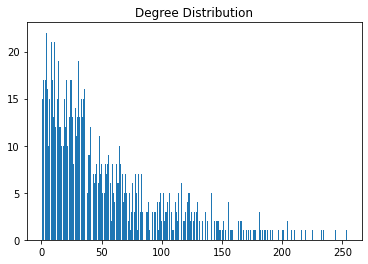

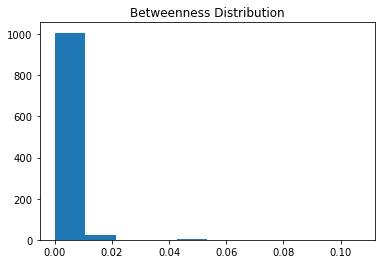

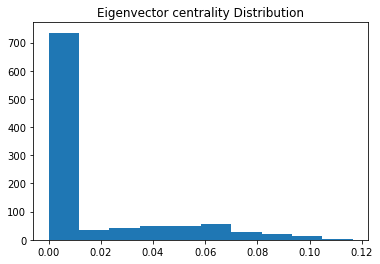

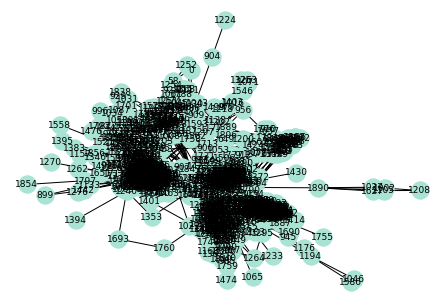

In [370]:
_, ego = network_viz(edgelist, vertices, directed=False, subgraph=None)

In [343]:
ego

{'diameter': 9,
 'clustering coefficient': 0.5264047980773336,
 'number of nodes': 1034,
 'number of edges': 26749,
 'number of connected components': 1,
 'size of largest connected component': 1034}

## 1b. Visualize and compare the global summaries of the 9 social circles in node 107 <a class="anchor" id="section1b"></a>

### Circle 0

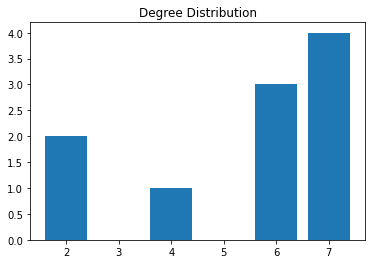

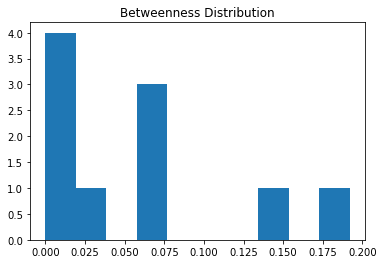

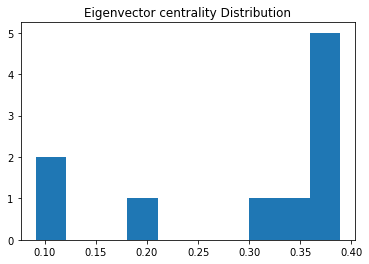

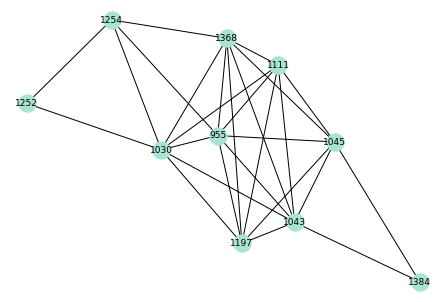

In [7]:
directed=False
_,circle0 = network_viz(edgelist, vertices, directed, circle_dict['circle0'])

### Circle 1

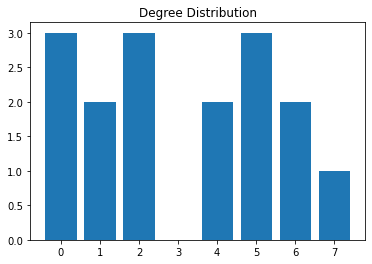

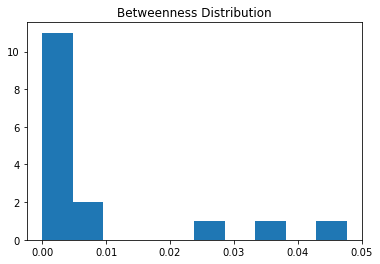

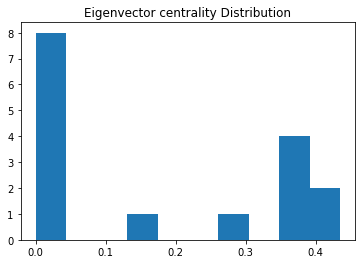

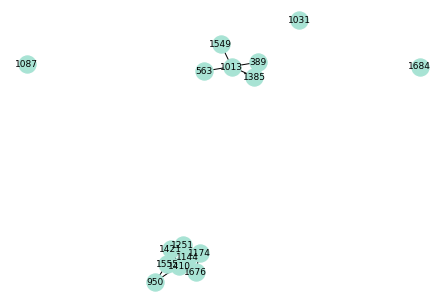

In [362]:
_,circle1 = network_viz(edgelist, vertices, directed, circle_dict['circle1'])

### Circle 2

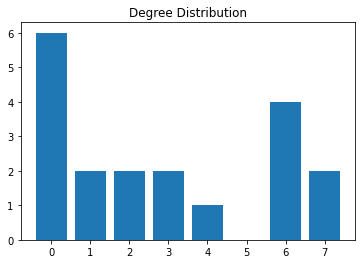

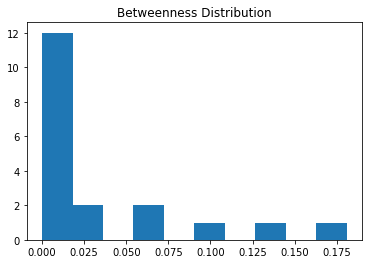

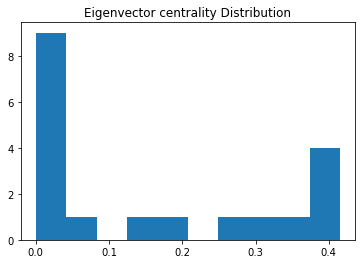

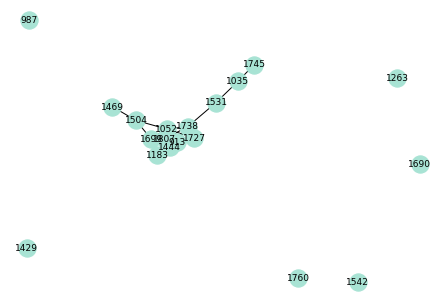

In [363]:
_,circle2 = network_viz(edgelist, vertices, directed, circle_dict['circle2'])

### Circle 3

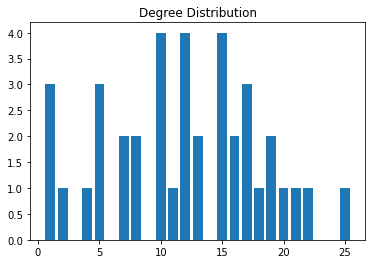

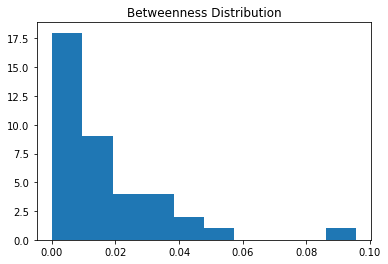

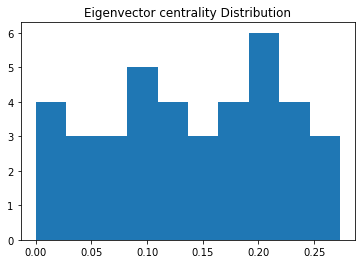

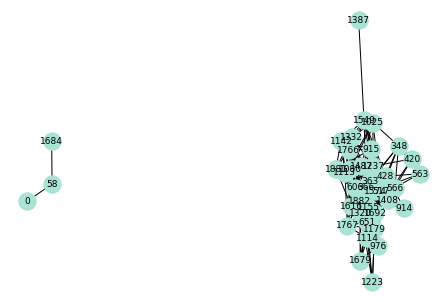

In [364]:
_,circle3 = network_viz(edgelist, vertices, directed, circle_dict['circle3'])

### Circle 4

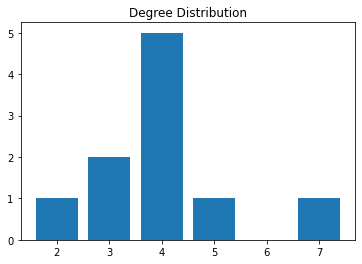

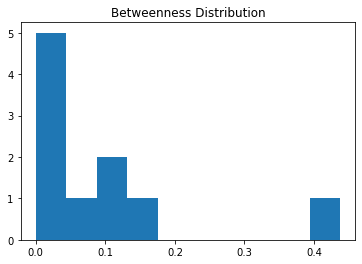

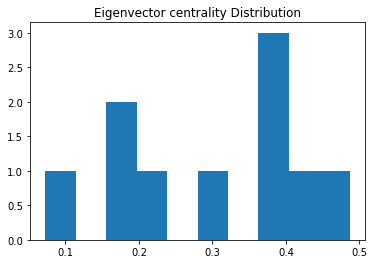

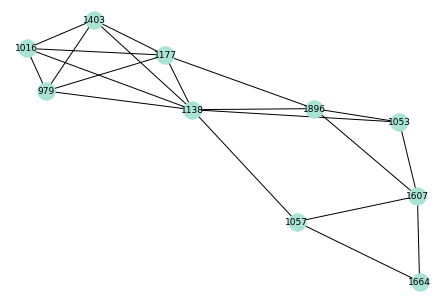

In [365]:
_,circle4 = network_viz(edgelist, vertices, directed, circle_dict['circle4'])

### Circle 5

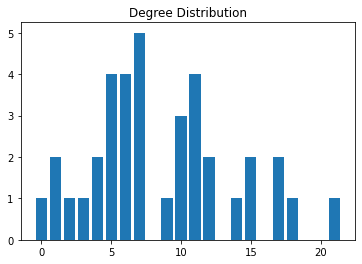

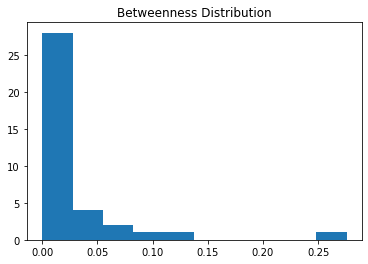

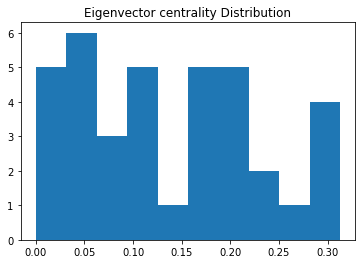

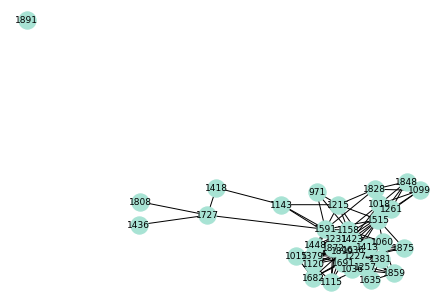

In [366]:
_,circle5 = network_viz(edgelist, vertices, directed, circle_dict['circle5'])

### Circle 6

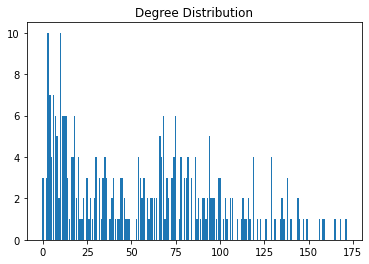

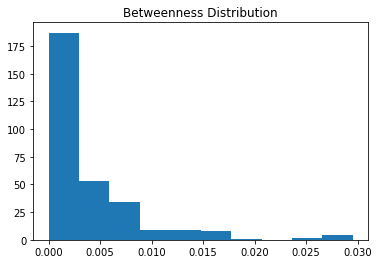

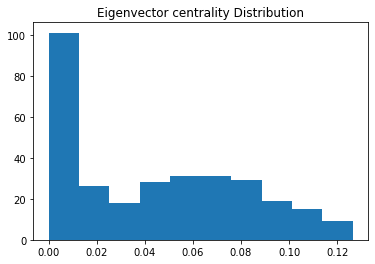

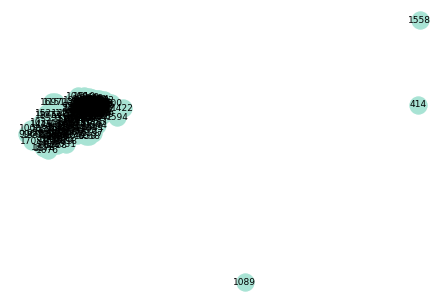

In [367]:
_,circle6 = network_viz(edgelist, vertices, directed, circle_dict['circle6'])

### Circle 7

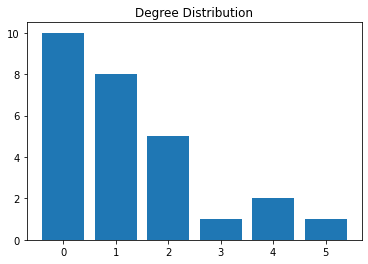

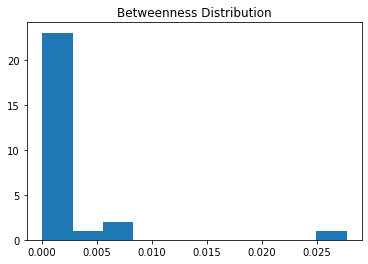

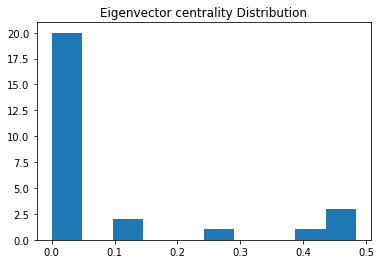

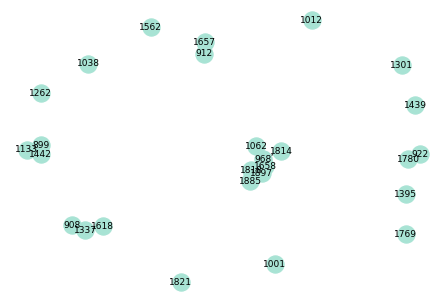

In [368]:
_,circle7 = network_viz(edgelist, vertices, directed, circle_dict['circle7'])

### Circle 8

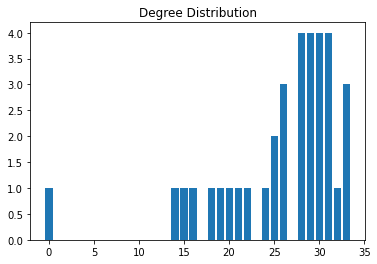

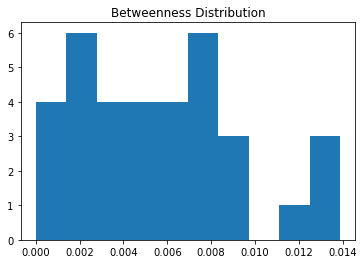

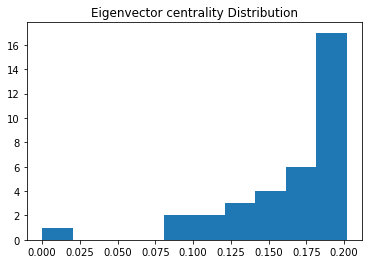

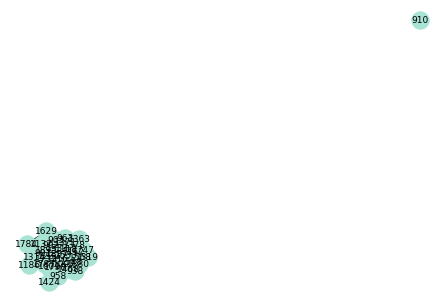

In [369]:
_, circle8 = network_viz(edgelist, vertices, directed, circle_dict['circle8'])

In [371]:
df = pd.DataFrame({'circle0':circle0, 
                   'circle1':circle1,
                   'circle2':circle2,
                   'circle3':circle3,
                   'circle4':circle4,
                   'circle5':circle5,
                   'circle6':circle6,
                   'circle7':circle7,
                   'circle8':circle8,
                   'ego': ego})

In [257]:
df = df.transpose()

,diameter,clustering coefficient,number of nodes,number of edges,number of connected components,size of largest connected component
circle0,3.0,0.812381,10.0,27.0,1.0,10.0
circle1,2.0,0.538690,16.0,25.0,5.0,8.0
circle2,6.0,0.335338,19.0,27.0,7.0,13.0
circle3,4.0,0.515104,39.0,233.0,2.0,36.0
circle4,3.0,0.691429,10.0,20.0,1.0,10.0
circle5,4.0,0.468422,37.0,159.0,2.0,36.0
circle6,5.0,0.530238,307.0,8612.0,4.0,304.0
circle7,3.0,0.245679,27.0,17.0,15.0,7.0
circle8,2.0,0.845503,35.0,450.0,2.0,34.0
ego,9.0,0.526405,1034.0,26749.0,1.0,1034.0


## Observations
1. **Diameter:** 
    - The diameter is a measure for how closely connected a network is. 
    - Circle2 has the largest diameter, meaning that it is the least connected - there is a higher degree of separation between people than in other social circles. 
    - Circle8 has the smallest diameter of 2, meaning that everyone in that cirlce is connected to every other person directly (path length = 1) or through a mutual friend (path length = 2)
2. **Clustering Coefficient:** 
    - The clustering coefficent is a measure of the ratio of potential triplets to actual triplets. It is a measure of how connected the network is. Unsurprisingly, diameter and clustering coefficient tend to be inversely related. Circles with a larger diameter tend to have smaller clustering coefficients. 
3. **Nodes:** 
    - Circle6 was the largest with 307 people. 
    - The smallest circle was Circle0 with only 10 people. 
    - There were two circles that had only 1 connected component. This means that everyone in circle0 is connected to at least 1 other person in that circle and likewise for circle4. These were also the two smallest circles, so it is unsurprising that they were connectd. 
4. **Edges:** 
    - Circle0 and Circle4 have the same number of nodes, yet Circle0 has 27 edges and Circle4 only has 20. This means Circle0 is more densely connected than Circle4. 
5. **Connected Components:** 
    - Circle5 and Circle8 both had two connected components where one of the connected components was a singleton. There are a few possible explanations for this: 
      - 1) The node was incorrectly placed in that circle. 
      - 2) The singleton represents someone who is a newcomer to the circle and user 107 was the first person from that cirlce to add them as a friend on Facebook. 
6. **Largest Connected Component:** 
    - The largest connected component also comes from the largest circle. 

# 2. Refactor Function to incorporate Girvan-Newman algorithm for community detection <a class="anchor" id="section2"></a>

Additions to local summary:
- clustering coefficient
- when directed=True: reciprocity 

Additions to global summary: 
- number of isolates
- when directed=True: 
    - average reciprocity
    - node with highest eigenvector 
    - node with highest betweenness 
    - node with highest closeness 
    - node with highest degree
- when directed=False: 
    - Girvan-Newman best partition cluster labels
    - modularity of Girvan-Newman best partition

Visualization:
- The network is now graphed using the Fruchterman-Reingold force-directed algorithm and nodes are colored according to the communities found using GN

In [278]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map


def analyze_subgraph(edgelist, directed, D, subgraph=None):
    """ 
    edgelist = list of tuples with edge endpoints --> get from node.edges
    vertices = list of all nodes --> obtained from edgelist 
    directed = True/False
    subgraph = a list of vertex labels from vertices you would like to visualize. 
    """
    if directed==True:
        return analyze_directed_subgraph(edgelist, directed, D, subgraph)
   
    G = nx.Graph()
    G.add_edges_from(edgelist)
    vertices = G.nodes

    # Filter vertices to include only those in subgraph
    if subgraph:
        SG = G.subgraph(subgraph)
    else:
        SG = G

    core_nodes = max(nx.connected_components(SG), key=len) 
    core = SG.subgraph(core_nodes) 

    fig, axes = plt.subplots(4, figsize=(6, 20)) 
    plt.tight_layout()
    
    # Degree 
    degree_sequence = [SG.degree(n) for n in SG.nodes]
    degree_dict = {n:SG.degree(n) for n in SG.nodes}
    max_degree_node = max(degree_dict, key=lambda x: degree_dict[x])
    degree_counts = Counter(degree_sequence)
    min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
    plot_x = list(range(min_degree, max_degree + 1))
    plot_y = [degree_counts.get(x, 0) for x in plot_x]
    degree_viz = axes[0].bar(plot_x, plot_y)
    axes[0].set_title('Degree Distribution')
    
    # Betweenness centrality distribution
    betweenness = nx.centrality.betweenness_centrality(core)
    betweenness_sequence = list(betweenness.values())
    max_btw_node = max(betweenness, key= lambda x: betweenness[x])
    sns.histplot(data=betweenness.values(), ax=axes[1])
    axes[1].set_title('Betweenness Distribution')

    # Eigenvector centrality distribution 
    eigen = nx.eigenvector_centrality(SG)
    eigen_sequence = list(eigen.values())
    max_eigen_node = max(eigen, key= lambda x: eigen[x])
    sns.histplot(data=eigen.values(), ax=axes[2])
    axes[2].set_title('Eigenvector centrality Distribution')
    
    # Closeness centrality
    closeness = nx.centrality.closeness_centrality(core)
    closeness_sequence = list(closeness.values())
    
    # Girvan-Newman - only for undirected 
    SG_copy = nx.Graph(SG)  # Create copy of subgraph to use for Girvan-Newman

    partition_sequence = []
    for _ in range(SG_copy.number_of_edges()//10): # Don't do all iterations until a singleton, just do 10% 
        my_edge_betweenness = nx.edge_betweenness_centrality(SG_copy)
        most_valuable_edge = max(SG_copy.edges(), key=my_edge_betweenness.get)
        SG_copy.remove_edge(*most_valuable_edge)
        my_partition = list(nx.connected_components(SG_copy))
        partition_sequence.append(my_partition)
    
    modularity_sequence = [nx.community.quality.modularity(SG,p) for p in partition_sequence]

    def my_modularity(partition):
        return nx.community.quality.modularity(SG, partition)

    best_partition = max(partition_sequence, key=my_modularity)
    best_partition_mod = nx.community.quality.modularity(SG, best_partition)

    best_partition_map = create_partition_map(best_partition)
    node_colors = [best_partition_map[n] for n in SG.nodes()]
    
    # Plot full subgraph
    pos = nx.spring_layout(SG) # draw using Fruchterman-Reingold force-directed algorithm
    nx.draw(SG, node_color=node_colors, pos=pos, ax=axes[3], node_size=30) # Kinda better but not really
    
    # Clustering coefficient
    cc = nx.clustering(SG)
    
    # Local summaries
    local_summary = {}
    for n in core.nodes:
        stats = {}
        stats['Eigenvector centrality'] = eigen[n]
        stats['Betweenness centrality'] = betweenness[n]
        stats['Degree'] = core.degree[n]
        stats['Closeness centrality'] = closeness[n]
        stats['clustering coefficient'] = nx.clustering(core, nodes=n)
        # stats['reciprocity'] = nx.reciprocity(core, nodes=n)
        local_summary[n] = stats
    
    # Global summary
    global_summary = {
        'Diameter': distance_measures.diameter(core),
        'Clustering coeff': cluster.average_clustering(SG),
        'Number of nodes': SG.number_of_nodes(),
        'Number of edges': SG.number_of_edges(),
        'Node with highest degree': max_degree_node, 
        'Node with highest eigenvector centrality': max_eigen_node,
        'Node with highest betweenness centrality': max_btw_node,
        'Isolates': nx.number_of_isolates(SG),
        'Connected components': nx.number_connected_components(SG), 
        'Size of largest connected component': len(max(nx.connected_components(SG), key=len)),
        'Girvan-Newman best partition cluster labels': best_partition_map,
        'Modularity of Girvan-Newman best partition': best_partition_mod}

    # Find the embeddings
    node2vec = Node2Vec(SG, dimensions=10)
    model = node2vec.fit() # embed nodes
    embeddings = model.wv.vectors
    
    return local_summary, global_summary, embeddings
    

In [205]:
def analyze_directed_subgraph(edgelist, directed, D, subgraph=None):
    """ 
    edgelist = list of tuples with edge endpoints --> get from node.edges
    vertices = list of all nodes --> obtained from edgelist 
    directed = True/False
    subgraph = a list of vertex labels from vertices you would like to visualize. 
    """

    G = nx.DiGraph()
    G.add_edges_from(edgelist)
    vertices = G.nodes

    # Filter vertices to include only those in subgraph
    if subgraph:
        SG = G.subgraph(subgraph)
    else:
        SG = G
    
    core_nodes = max(nx.strongly_connected_components(SG), key=len)
    core = SG.subgraph(core_nodes)

    fig, axes = plt.subplots(7, figsize=(6, 20))
    plt.tight_layout()
    
    # Degree 
    degree_sequence = [SG.degree(n) for n in SG.nodes]
    degree_dict = {n:SG.degree(n) for n in SG.nodes}
    max_degree_node = max(degree_dict, key=lambda x: degree_dict[x])
    degree_counts = Counter(degree_sequence)
    min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
    plot_x = list(range(min_degree, max_degree + 1))
    plot_y = [degree_counts.get(x, 0) for x in plot_x]
    degree_viz = axes[0].bar(plot_x, plot_y)
    axes[0].set_title('Degree Distribution')
    
    # In-degree
    degree_sequence = [SG.in_degree(n) for n in SG.nodes]
    in_degree_dict = {n:SG.in_degree(n) for n in SG.nodes}
    max_in_degree_node = max(in_degree_dict, key=lambda x: in_degree_dict[x])
    degree_counts = Counter(degree_sequence)
    min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
    plot_x = list(range(min_degree, max_degree + 1))
    plot_y = [degree_counts.get(x, 0) for x in plot_x]
    axes[1].bar(plot_x, plot_y)
    axes[1].set_title('In Degree Distribution')
    

    # Out-degree
    degree_sequence = [SG.out_degree(n) for n in SG.nodes]
    out_degree_dict = {n:SG.out_degree(n) for n in SG.nodes}
    max_out_degree_node = max(out_degree_dict, key=lambda x: out_degree_dict[x])
    degree_counts = Counter(degree_sequence)
    min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
    plot_x = list(range(min_degree, max_degree + 1))
    plot_y = [degree_counts.get(x, 0) for x in plot_x]
    axes[2].bar(plot_x, plot_y)
    axes[2].set_title('Out Degree Distribution')
    
    # Betweenness centrality distribution
    betweenness = nx.centrality.betweenness_centrality(core)
    betweenness_sequence = list(betweenness.values())
    max_btw_node = max(betweenness, key= lambda x: betweenness[x])
    sns.histplot(data=betweenness.values(), ax=axes[3],discrete=True)
    axes[3].set_title('Betweenness Distribution')

    
    # Eigenvector centrality distribution 
    eigen = nx.eigenvector_centrality(SG)
    eigen_sequence = list(eigen.values())
    max_eigen_node = max(eigen, key= lambda x: eigen[x])
    sns.histplot(data=eigen.values(), ax=axes[4])
    axes[4].set_title('Eigenvector Centrality Distribution')
    
    # Return the reciprocity for each vertex and the avg reciprocity            
    rec = nx.reciprocity(SG, vertices)
    avg_rec = nx.reciprocity(SG)
    sns.histplot(data=rec.values(), ax=axes[5])
    axes[5].set_title('Reciprocity Distribution')

    # Closeness centrality
    closeness = nx.centrality.closeness_centrality(core)
    closeness_sequence = list(closeness.values())
    

    # Local summary for largest conneected component 
    local_summary = {}
    for n in core.nodes:
        stats = {}
        stats['Eigenvector centrality'] = eigen[n]
        stats['Betweenness centrality'] = betweenness[n]
        stats['Degree'] = core.degree[n]
        stats['Closeness centrality'] = closeness[n]
        stats['Clustering coefficient'] = nx.clustering(core, nodes=n)
        stats['Reciprocity'] = nx.reciprocity(core, nodes=n)
        local_summary[n] = stats
    
    # Global summaries 
    global_summary = {
        'Diameter': distance_measures.diameter(core),
        'Clustering coeff': cluster.average_clustering(SG),
        'Number of nodes': SG.number_of_nodes(),
        'Number of edges': SG.number_of_edges(),
        'Node with highest degree': max_degree_node, 
        'Node with highest in-degree': max_in_degree_node,
        'Node with highest out-degree': max_out_degree_node,
        'Node with highest eigenvector centrality': max_eigen_node,
        'Node with highest betweenness centrality': max_btw_node,
        'Number of isolates': nx.number_of_isolates(SG),
        'Average reciprocity': avg_rec}

    
    pos = nx.spring_layout(SG) # draw using Fruchterman-Reingold force-directed algorithm
    nx.draw(SG, with_labels=True, font_size=9, node_color='#a8e3d4', pos=pos, ax=axes[6]) # Kinda better but not really
    
    # Find the embeddings
    node2vec = Node2Vec(SG, dimensions=10)
    model = node2vec.fit() # embed nodes
    embeddings = model.wv.vectors

    return local_summary, global_summary, embeddings

### 2a. Test the function on a toy dataset <a class="anchor" id="section2a"></a>
Generate toy dataset with 20 nodes with two complete graphs of size 10 and connect them via just one edge.

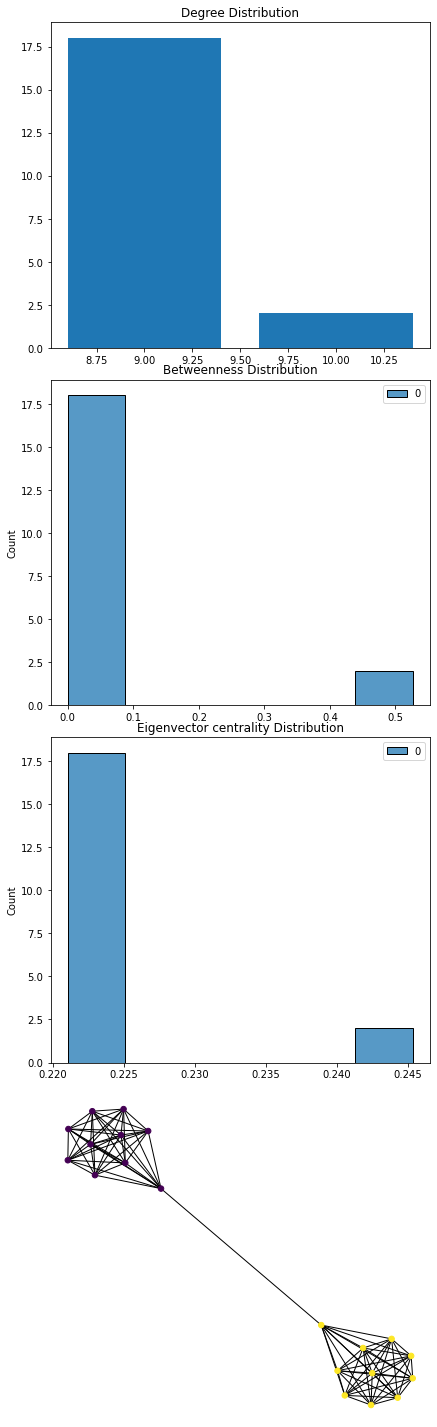

In [276]:
# Create Toy dataset with 2 communities 

vertices = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
            '11', '12', '13', '14', '15', '16', '17', '18','19', '20']
first = vertices[:10]
second = vertices[10:]

edgelist1 = [(v,w) for v in first for w in first if w != v]
edgelist2 = [(v,w) for v in second for w in second if w != v]

edgelist_toy = edgelist1 + edgelist2
            
edgelist_toy.append(('10', '11'))
edgelist_toy.append(('11','10'))


l,g = analyze_subgraph(edgelist_toy, directed=False, subgraph=None)

## 2b. Visualize the communities in node 0 <a class="anchor" id="section2b"></a>
For node 0 I ran Girvan-Newman for up to 20% of the graph size since this network was smaller. 

CPU times: user 1min 29s, sys: 73.5 ms, total: 1min 30s
Wall time: 1min 30s


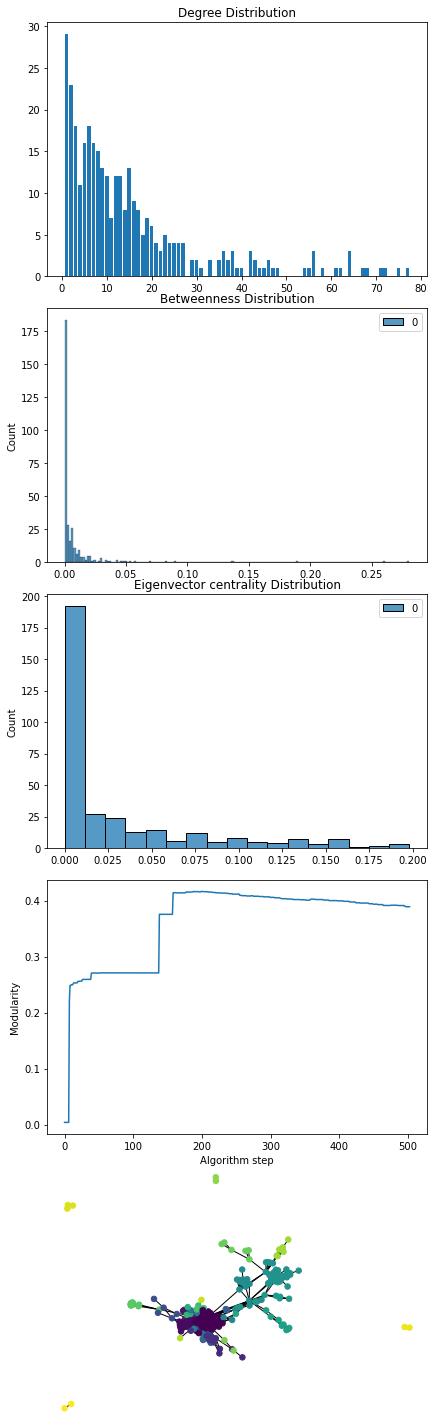

In [33]:
%%time
ls,gs = analyze_subgraph(edgelist0, directed=False, subgraph=None)

#### Color the nodes of 0 according to the social circle labels

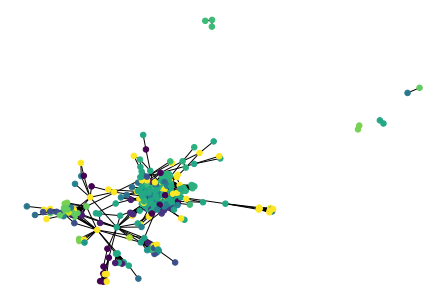

In [31]:
edgelist = edgelist0
circle_dict = circle_dict0

G = nx.Graph()
G.add_edges_from(edgelist)

circle_partitions = [nodes for nodes in circle_dict.values()]
partition_map = create_partition_map(circle_partitions)  
node_colors = []
for n in G.nodes():
    if n not in partition_map:
        node_colors.append(len(circle_dict)+1)
    else: node_colors.append(partition_map[n])


pos = nx.spring_layout(G) 
nx.draw(G, node_color=node_colors, pos=pos, node_size=30) 

## 2c. Visualize the communities in node 107 <a class="anchor" id="section2c"></a>
I ran Girvan-Newman for k=2 up to 10% of the graph size since this network is much larger than node 0's network

CPU times: user 4h 45min 55s, sys: 15.2 s, total: 4h 46min 10s
Wall time: 4h 46min 17s


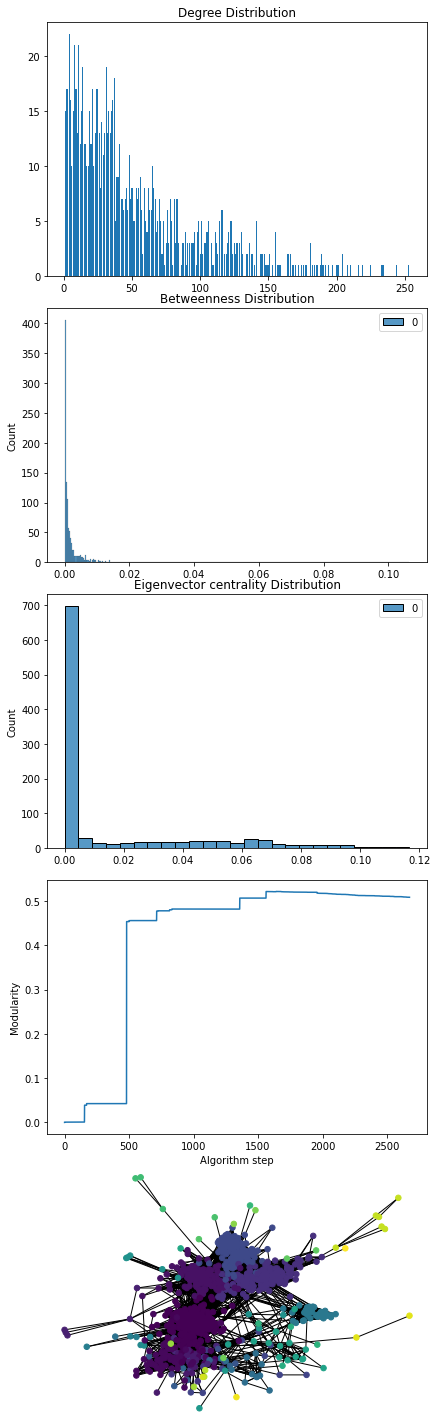

In [35]:
%%time
ls107,gs107 = analyze_subgraph(edgelist107, directed=False, subgraph=None)

#### Color the nodes of 107 according to the ground truth FB social circle labels <a class="anchor" id="section2ci"></a>

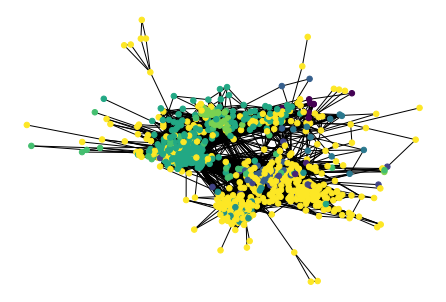

In [36]:
edgelist = edgelist107
circle_dict = circle_dict107

G = nx.Graph()
G.add_edges_from(edgelist)

circle_partitions = [nodes for nodes in circle_dict.values()]
partition_map = create_partition_map(circle_partitions)  
node_colors = []
for n in G.nodes():
    if n not in partition_map:
        node_colors.append(len(circle_dict)+1)
    else: node_colors.append(partition_map[n])


pos = nx.spring_layout(G) 
nx.draw(G, node_color=node_colors, pos=pos, node_size=30) 

## 2d. Bar chart of community distribution <a class="anchor" id="section2d"></a>

### Create a df with info about Node 0

In [203]:
def create_df(global_summary, circle_dict):

    # Create a counter dictionary 
    community_sizes = Counter(global_summary['Girvan-Newman best partition cluster labels'].values())

    # Sort to get the 5 most common
    top5 = community_sizes.most_common()[:5] # most_common() sorts by values

    top5_labels = [x[0] for x in top5]
    
    # Get GN vertices and labels 
    GN_dict = global_summary['Girvan-Newman best partition cluster labels']
    GN_vertices = set(GN_dict.keys()) 
    GN_label = GN_dict.values()
    
    # Create vertex:fb circle dictionary 
    FB_dict = {}
    
    FB_nodes = [x for circle in circle_dict.values() for x in circle]
    
    for node in FB_nodes:
        for circle in circle_dict.items():
            if node in circle[1]:
                FB_dict[node] = circle[0]

    # Get FB vertices and labels 
    FB_vertices = set(FB_dict.keys())
    FB_circle = FB_dict.values()

    # Find intersection of GN and FB vertices
    final_vertices = GN_vertices.intersection(FB_vertices) 

    # Keep
    final_GN_dict = {}
    for key, value in GN_dict.items():
        if key in final_vertices:
            final_GN_dict[key] = value

    final_FB_dict = {}
    for key, value in FB_dict.items():
        if key in final_vertices:
            final_FB_dict[key] = value

    df_FB = pd.DataFrame({'vertex':final_FB_dict.keys(), 'circle label': final_FB_dict.values()})
    df_GN = pd.DataFrame({'vertex':final_GN_dict.keys(), 'community label': final_GN_dict.values()})
    df_FB['vertex'] = df_FB['vertex'].astype(int)
    df_GN['vertex'] = df_GN['vertex'].astype(int)
    df_FB.sort_values(['vertex'], inplace=True)
    df_GN.sort_values(['vertex'], inplace=True)

    df = df_FB.merge(df_GN, how='left', on='vertex')

    # Include only the 5 largest communities 
    df_top5 = df.loc[df['community label'].isin(top5_labels)]
    
    return df, df_top5

In [202]:
df_107, df_top5_107 = create_df(gs107, circle_dict107)
df_107

481


,vertex,circle label,community label
0,0,circle3,9
1,58,circle3,9
2,348,circle3,2
3,363,circle3,2
4,366,circle3,2
...,...,...,...
475,1896,circle4,26
476,1897,circle7,2
477,1899,circle5,10
478,1900,circle6,0


In [212]:
df_0, df_top5_0 = create_df(gs, circle_dict0)
df_0

,vertex,circle label,community label
0,1,circle15,1
1,2,circle10,18
2,3,circle15,0
3,5,circle16,0
4,6,circle15,30
...,...,...,...
272,342,circle15,0
273,343,circle19,18
274,344,circle4,0
275,345,circle15,0


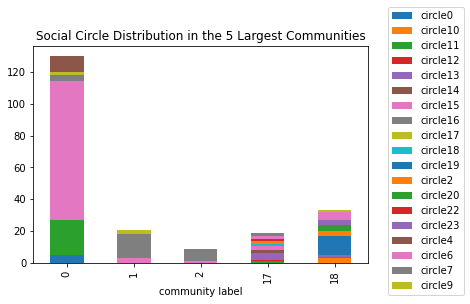

In [214]:
# Node 0
df_plot0 = df_top5_0.groupby(['circle label', 'community label']).size().reset_index().pivot(columns='circle label', index='community label', values=0)

df_plot0.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.3, 1.2))
plt.title("Social Circle Distribution in the 5 Largest Communities")
plt.show()

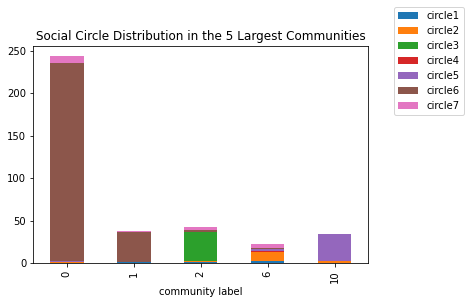

In [215]:
# Node 107
df_plot107 = df_top5_107.groupby(['circle label', 'community label']).size().reset_index().pivot(columns='circle label', index='community label', values=0)

df_plot107.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.3, 1.2))
plt.title("Social Circle Distribution in the 5 Largest Communities")
plt.show()

### Compare similarity between cluster labels and social circle labels <a class="anchor" id="section2e"></a> 
Note: There are some vertices that belong to more than one circle. In this case, I just select the last circle in the list for  as the final FB circle label 

In [210]:
# Adjusted rand score for node 0
ar_score = adjusted_rand_score(df_0['circle label'], df_0['community label']) # labels_true, labels_pred
ar_score

0.33524993488885774

In [211]:
# Adjusted rand score for node 107
ar_score107 = adjusted_rand_score(df_107['circle label'], df_107['community label']) # labels_true, labels_pred
ar_score107

0.5966140405983669

#### Remark
Community detection performed better for node 107 than for node 0. I think community detection perforfmed better on node 107 because it had fewer social circles than node 0. Node 107 has 9 social circles while node 0 had 24 circles. It seems that the more communities, the harder it will be to accurately capture each one. 

# 3. Community detection with node2vec <a class="anchor" id="section3"></a>

### 3a. Get embeddings for toy graph <a class="anchor" id="section3a"></a>

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


array([[-0.19483204,  0.14123052,  0.3789837 , -0.24795073,  0.7782931 ,
         0.1826159 ,  0.92091805,  0.2960149 , -0.5146906 ,  0.4007186 ],
       [ 0.25896108, -0.52799493, -0.20258436, -0.7019456 ,  0.154364  ,
         0.52598494,  0.4526111 , -0.00926355,  0.37731236,  0.76419467],
       [-0.10514992,  0.22722618,  0.37296137, -0.3069511 ,  0.92703575,
         0.22811134,  0.85142547,  0.28753462, -0.57234734,  0.37996   ],
       [-0.36338958,  0.19304909,  0.5379024 , -0.3920579 ,  0.9464685 ,
         0.22014762,  1.0483643 ,  0.12273574, -0.6310315 ,  0.2800196 ],
       [ 0.12998268, -0.514985  , -0.27524018, -0.83082473,  0.15391165,
         0.5396051 ,  0.302387  ,  0.08888283,  0.5466716 ,  1.0105761 ],
       [-0.35313186,  0.25275144,  0.30090117, -0.17483206,  0.96782255,
         0.18198235,  0.8897816 ,  0.10970026, -0.5934563 ,  0.45026645],
       [-0.35037115,  0.3518972 ,  0.25402918, -0.4164464 ,  0.9414931 ,
         0.27389804,  0.82981014,  0.18656342

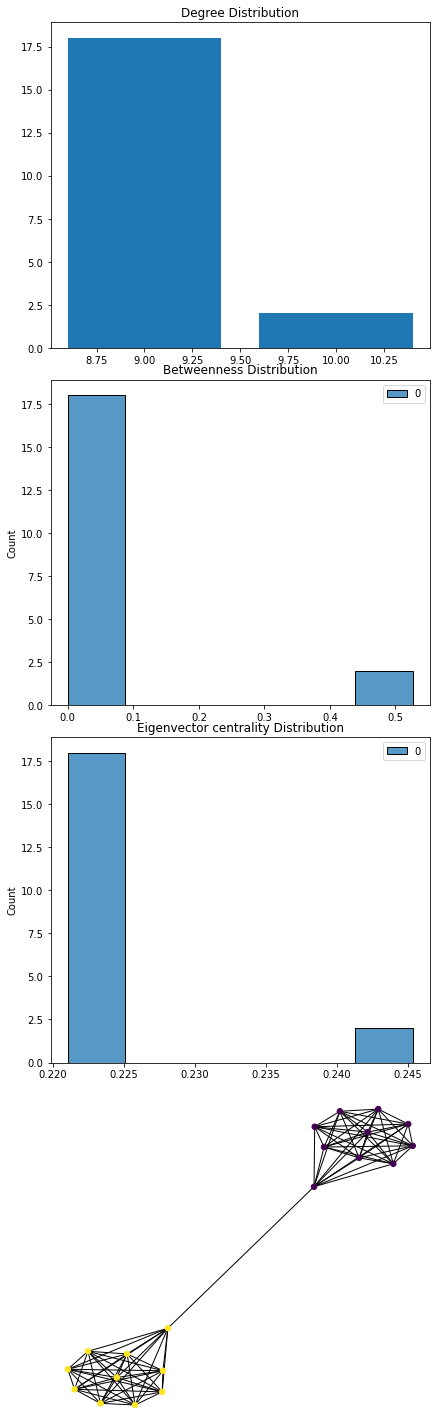

In [279]:
# Verify that I can return an embedding on the toy dataset 
l,g, emb = analyze_subgraph(edgelist_toy, directed=False, D=10, subgraph=None)
emb

## 3b. Run node2vec on node 0 and 107 <a class="anchor" id="section3b"></a>

In [233]:
def get_embeddings(edgelist, D):

    G = nx.Graph()
    G.add_edges_from(edgelist)
    vertices = G.nodes
    
    node2vec = Node2Vec(G, dimensions=10) # Find the embeddings
    model = node2vec.fit() 
    embeddings = model.wv.vectors # Returns list of embeddings for each node
    idx_key = model.wv.index_to_key # Returns a list of the node labels in order of 
    
    return embeddings, idx_key
    

In [236]:
emb0, idx_key0 = get_embeddings(edgelist0,D=30)
emb107, idx_key107 = get_embeddings(edgelist107,D=30)

Computing transition probabilities:   0%|          | 0/1034 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


### i) Cluster the nodes using the node embeddings matrix <a class="anchor" id="section3bi"></a>

In [266]:
kmeans = KMeans(n_clusters=24, random_state=0).fit(emb0) # 24 social circles 
kmeans_labels0 = kmeans.labels_

In [267]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(emb107) # 9 social circles 
kmeans_labels107 = kmeans.labels_

### ii) How well does Kmeans do compared to community detection? <a class="anchor" id="section3bii"></a>

In [268]:
def df_kmeans(circle_dict, idx_key, kmeans_labels):

    FB_dict = {}
    FB_nodes = [x for circle in circle_dict.values() for x in circle]

    for node in FB_nodes:
        for circle in circle_dict.items():
            if node in circle[1]:
                FB_dict[node] = circle[0]

    df_FB = pd.DataFrame({'vertex':FB_dict.keys(),'circle label':FB_dict.values()})
    df_KM = pd.DataFrame({'vertex':idx_key, 'kmeans cluster label':kmeans_labels})

    df = df_FB.merge(df_KM, how='left', on='vertex').dropna()
    return df

In [269]:
df0 = df_kmeans(circle_dict0, idx_key0, kmeans_labels0)

ar_score_kmeans0 = adjusted_rand_score(df0['circle label'], df0['kmeans cluster label']) # labels_true, labels_pred
ar_score_kmeans0

0.20665138871520483

In [271]:
df107 = df_kmeans(circle_dict107, idx_key107,kmeans_labels107)

ar_score_kmeans107 = adjusted_rand_score(df107['circle label'], df107['kmeans cluster label']) # labels_true, labels_pred
ar_score_kmeans107

0.5083005350758149

#### Remarks:
Turns out that community detection beats kmeans clustering. Below is a table summarizing the adjusted rand score results for each. 

| Node     | Community Detection | Kmeans |
|----------|---------------------|--------|
|0         | 0.335               | 0.206 |
|107       | 0.596               | 0.508 |

## 3c. Build a better prediction model with a Gradient Boosting Classifier <a class="anchor" id="section3c"></a>
Input: node embeddings <br>
Output: social circle label

In [342]:
# NODE 0 
# Get the labels in the correct order and feed into model as numpy arrays 

label_emb0 = []
for label, emb in zip(idx_key0, emb0):
    label_emb0.append((int(label), emb))
    
label_emb0 = sorted(label_emb0, key=lambda x: x[0]) # has label + embedding

emb_labels_only0 = set([x[0] for x in label_emb0])
emb_labels_only0

FB_dict0 = {}
FB_nodes = [x for circle in circle_dict0.values() for x in circle]

for node in FB_nodes:
    for circle in circle_dict0.items():
        if node in circle[1]:
            FB_dict0[int(node)] = circle[0]
FB_dict0

FB_labels_only0 = set([x for x in FB_dict0.keys()])
FB_labels_only0

final_labels0 = list(emb_labels_only0.intersection(FB_labels_only0))
final_labels0 = sorted(final_labels0)

final_emb0 = []
for tup in label_emb0:
    if tup[0] in final_labels0:
        final_emb0.append(tup[1])
        
X = np.array(final_emb0)

y = []
for label in final_labels0:
    y.append(FB_dict0[label])
y = np.array(y)

le = LabelEncoder()
le.fit(y)
y = le.transform(y)


In [353]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)


In [354]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
print("Starting f1 score:", round(f1,3))

Starting f1 score: 0.493


In [355]:
# Hyperparameter tuning

clf =  XGBClassifier()

search_space = {'eta': [0.3, 0.2, 0.1, 0.05, 0.01], # Typical final values used are between 0.01-0.2
                 'max_depth': [3,6,9], # Typical values: 3-10
                 'max_delta_step': [0,2,4,6,8,10], # Can help with imbalanced classes, default=0
                 'subsample': [0.5, 0.8, 1], # Fraction of observations to be randomly sampled from for each tree. Default=1
                 'colsample_bytree': [0.5, 0.8,1], # Fraction of columns to be randomly sampled for each tree 
                 'scale_pos_weight':[0.2, 0.4, 0.6, 0.8, 1]} #Default 1. For unbalanced classes, use sum(neg)/sum(pos)

clf_rand = RandomizedSearchCV(estimator=clf, 
                            param_distributions=search_space, 
                            n_iter=5,
                            cv=5,
                            verbose=True)

clf_rand.fit(X_train, y_train)
clf_rand.best_estimator_.get_params()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[19:15:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ameetan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ameetan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.2s finished


[19:15:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'objective': 'multi:softprob',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.100000001,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eta': 0.1}

In [363]:
# Fit model
best_params = {'eta': 0.1, # Typical final values used are between 0.01-0.2
               'max_depth': 6, # Typical values: 3-10
               'colsample_bytree': 1, # default=0
               'subsample': 0.8} # Fraction of observations to be randomly sampled from for each tree. Default=1


xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

[19:16:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [364]:
y_pred = xgb.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
print("Final f1 score:", round(f1,3))

Final f1 score: 0.48


##### Interestingly, after hyperparameter tuning my f1 score went down slightly for node 0. Let's see what happens when I run it on node 107.  

In [365]:
# NODE 1 
# Get the labels in the correct order and feed into model as numpy arrays 

label_emb107 = []
for label, emb in zip(idx_key107, emb107):
    label_emb107.append((int(label), emb))
    
label_emb107 = sorted(label_emb107, key=lambda x: x[0]) # has label + embedding

emb_labels_only107 = set([x[0] for x in label_emb107])
emb_labels_only107

FB_dict107 = {}
FB_nodes = [x for circle in circle_dict107.values() for x in circle]

for node in FB_nodes:
    for circle in circle_dict107.items():
        if node in circle[1]:
            FB_dict107[int(node)] = circle[0]

FB_labels_only107 = set([x for x in FB_dict107.keys()])
FB_labels_only107

final_labels107 = list(emb_labels_only107.intersection(FB_labels_only107))
final_labels107 = sorted(final_labels107)

final_emb107 = []
for tup in label_emb107:
    if tup[0] in final_labels107:
        final_emb107.append(tup[1])
        
X = np.array(final_emb107)

y = []
for label in final_labels107:
    y.append(FB_dict107[label])
y = np.array(y)

le = LabelEncoder()
le.fit(y)
y = le.transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

In [366]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
print("Starting f1 score:", round(f1,3))

Starting f1 score: 0.873


In [367]:
# Hyperparameter tuning

clf =  XGBClassifier()

search_space = {'eta': [0.3, 0.2, 0.1, 0.05, 0.01], # Typical final values used are between 0.01-0.2
                 'max_depth': [3,6,9], # Typical values: 3-10
                 'max_delta_step': [0,2,4,6,8,10], # Can help with imbalanced classes, default=0
                 'subsample': [0.5, 0.8, 1], # Fraction of observations to be randomly sampled from for each tree. Default=1
                 'colsample_bytree': [0.5, 0.8,1], # Fraction of columns to be randomly sampled for each tree 
                 'scale_pos_weight':[0.2, 0.4, 0.6, 0.8, 1]} #Default 1. For unbalanced classes, use sum(neg)/sum(pos)

clf_rand = RandomizedSearchCV(estimator=clf, 
                            param_distributions=search_space, 
                            n_iter=5,
                            cv=5,
                            verbose=True)

clf_rand.fit(X_train, y_train)
clf_rand.best_estimator_.get_params()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[19:23:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:23:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ameetan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ameetan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:23:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.5s finished


{'objective': 'multi:softprob',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.100000001,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0.8,
 'subsample': 0.5,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eta': 0.1}

In [368]:
# Fit model
best_params = {'eta': 0.1, # Typical final values used are between 0.01-0.2
               'max_depth': 6, # Typical values: 3-10
               'colsample_bytree': 0.8, # default=0
               'subsample': 0.5} # Fraction of observations to be randomly sampled from for each tree. Default=1


xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

[19:23:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [369]:
y_pred = xgb.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
print("Final f1 score:", round(f1,3))

Final f1 score: 0.876


#### Horray! 
This time the f1 score actually went up after hyperparameter tuning. XGBClassifier was able to do a much better job on node 107 than on node 0. This is unsurprising given that there was more data and fewer classes to classify. 

# 4. Degrees of Separation <a class="anchor" id="section4"></a>
In 2016, Facebook did a "6 degrees of separation" experiment and found that on average, two people are 3.57 degrees apart. Here I repeat this experiment with this data by doing the following steps:
1. Choose 2 nodes at random
2. Calculate the shortest path between the two and store this value
3. Repeat 1000 times to create a distribution

In [3]:
C = nx.read_edgelist('facebook_combined.txt')

In [4]:
C_nodes = list(C.nodes)

In [7]:
lengths = []
for _ in range(1000):
    nodes = np.random.choice(C_nodes, 2, replace=False)
    lengths.append(len(nx.shortest_path(C, 
                                        source=nodes[0], 
                                        target=nodes[1])))

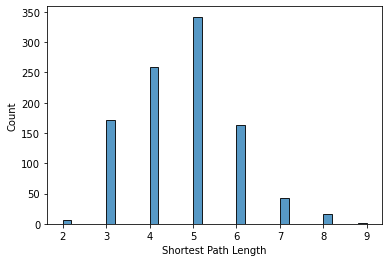

In [8]:
sns.histplot(data=lengths)
plt.xlabel('Shortest Path Length')
plt.show()

In [9]:
np.mean(lengths)

4.68